# Classifying Knee Images

## 1 Imports

In [1]:
# omit tensorflow import futurewarnings
import warnings
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
print('TensorFlow version: ', tf.__version__)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout

from tensorflow import keras
from tensorflow.keras import Model, preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory

TensorFlow version:  2.5.0


## 2 Load the data

In [2]:
directory = "../data/"

train_directory = directory + "train"
test_directory = directory + "test"
val_directory = directory + "val"

In [3]:
batch_size = 32
img_height = 224
img_width = 224

def fetch_image_data_from_directory( dir_path ):
    return tf.keras.preprocessing.image_dataset_from_directory(
    dir_path,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    smart_resize=False,
)

In [4]:
train_dataset = fetch_image_data_from_directory(train_directory)

Found 25 files belonging to 5 classes.


In [5]:
test_dataset = fetch_image_data_from_directory(test_directory)

Found 25 files belonging to 5 classes.


In [6]:
val_dataset = fetch_image_data_from_directory(val_directory)

Found 25 files belonging to 5 classes.


## 3 Explore the data

In [7]:
print('Training data: ', train_dataset.element_spec)
print('Testing data: ', test_dataset.element_spec)
print('Validation data: ', val_dataset.element_spec)

Training data:  (TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Testing data:  (TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Validation data:  (TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [8]:
sns.set_style("dark")

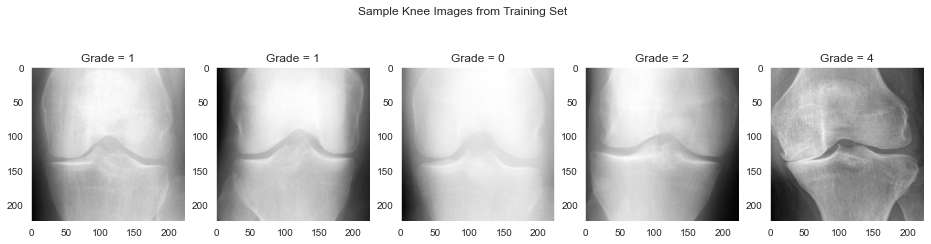

In [9]:
plt.figure(figsize=(16, 4))
for images, labels in train_dataset.take(1):
    for i in range(5):
        ax = plt.subplot(1,5,i+1)
        plt.imshow(images[i].numpy().astype('uint8'),cmap='gray')
        ax.set_title('Grade = ' + str(labels[i].numpy()))
_ = plt.suptitle('Sample Knee Images from Training Set')

In [10]:
def plot_distribution(dataset, title):
    for features, label in dataset.take(1):
        f, ax = plt.subplots(figsize=(16,6))
        g = sns.histplot(label.numpy(), bins=5, discrete=True, ax=ax)
        plt.xticks(range(5))
        plt.xlabel('Knee Severity Grade')
        plt.title(title)

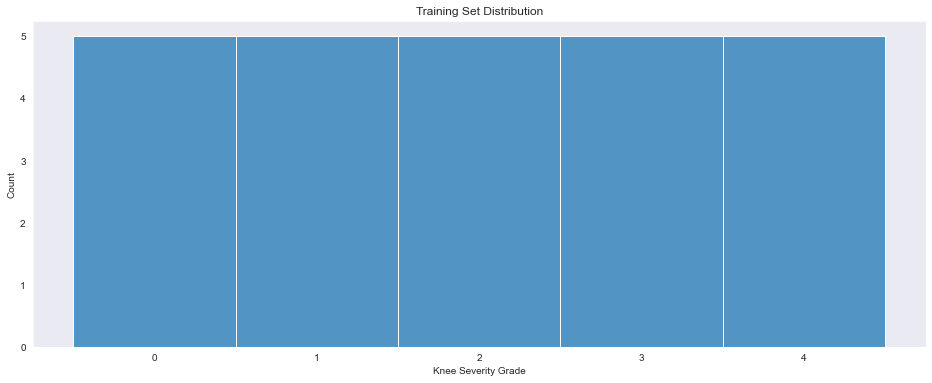

In [11]:
plot_distribution(train_dataset, 'Training Set Distribution')

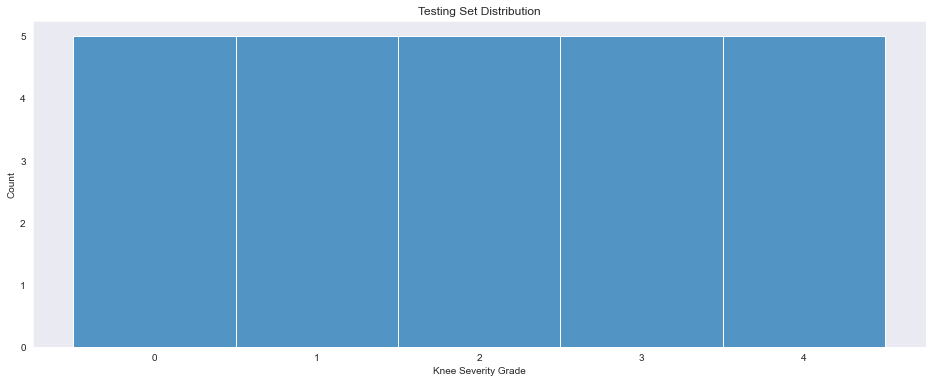

In [12]:
plot_distribution(test_dataset, 'Testing Set Distribution')

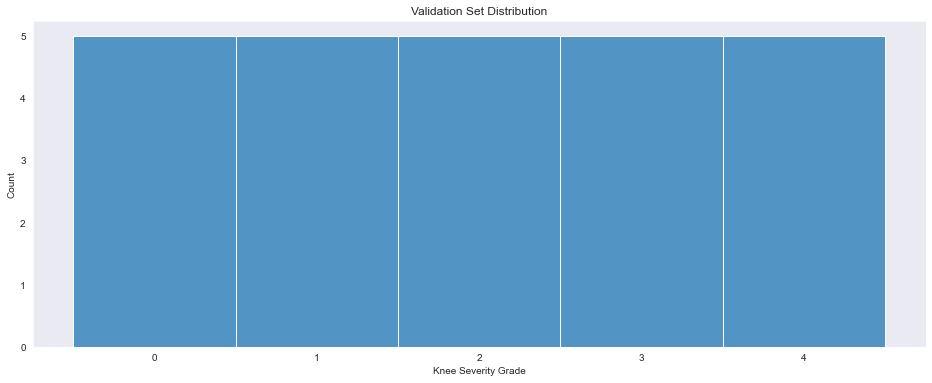

In [13]:
plot_distribution(val_dataset, 'Validation Set Distribution')

## 4 Model

In [14]:
num_classes = 5

model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(img_height, img_width, 1), padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes))

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 55, 55, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 96800)             0

In [19]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=3)

Epoch 1/3
1/1 [==============================] - 1s 1s/step - loss: 1830.1136 - accuracy: 0.2000 - val_loss: 385.0880 - val_accuracy: 0.2000
Epoch 2/3
1/1 [==============================] - 1s 1s/step - loss: 1074.0570 - accuracy: 0.2000 - val_loss: 204.2700 - val_accuracy: 0.2000
Epoch 3/3
1/1 [==============================] - 2s 2s/step - loss: 619.4521 - accuracy: 0.2000 - val_loss: 135.4904 - val_accuracy: 0.2000


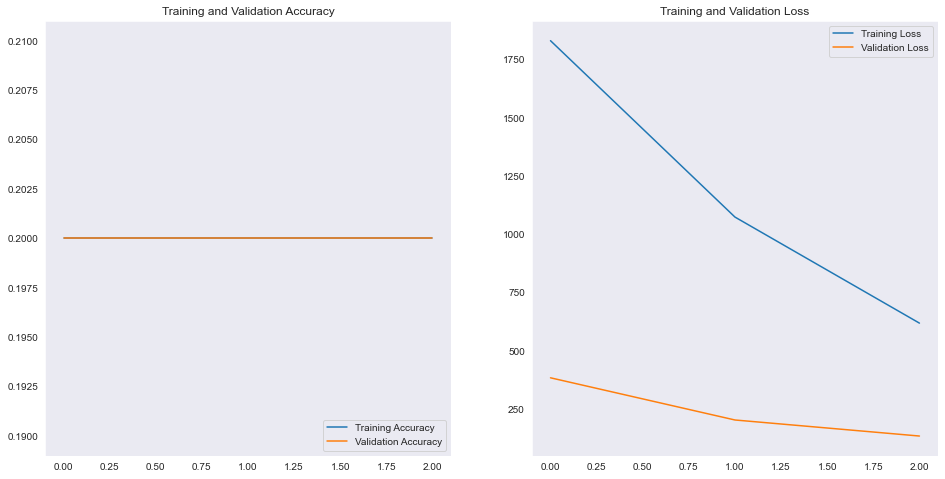

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(3)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
predictions = model.predict(test_dataset, batch_size=32, verbose=1)

1/1 [==============================] - 0s 367ms/step


In [27]:
print(predictions.shape)

(25, 5)


In [29]:
print(predictions[0])
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(np.argmax(score), 100 * np.max(score))
)

[ -62.457153 -221.96104    11.406692   58.86842   131.54193 ]
This image most likely belongs to 4 with a 100.00 percent confidence.


In [32]:
for image_batch, labels_batch in test_dataset:
    print(image_batch.shape)
    print(labels_batch.shape)
    print(labels)

(25, 224, 224, 1)
(25,)
tf.Tensor([1 1 0 2 4 1 3 4 3 1 4 4 0 3 4 0 2 2 1 3 3 2 0 2 0], shape=(25,), dtype=int32)
